# Data Exploration & Feature Engineering

This notebook documents the discovery and preparation phase of our project. It serves as a comprehensive Lab Journal for our data strategy, detailing why specific variables were selected, transformed, or excluded based on statistical evidence.

### Objectives

* **Data Exploration (EDA):** Identifying distributions, anomalies, and domain-integrity constraints.
* **Data Cleaning:** Handling missing values and rectifying structural inconsistencies.
* **Feature Engineering:** Encoding categorical variables and deriving new features.
* **Feature Selection:** Justifying the inclusion or exclusion of variables through correlation analysis and visual inspection.

### Project Architecture

To ensure reproducibility and clean production code, we follow a modular structure:

* this notebook: contains the narrative, visual analysis, and "proof of work" for rejected hypotheses.
* `/src` directory: contains the finalized Python scripts used to generate the modeling-ready dataset.

---

### Tips for your GitHub Presentation:

1. **Use Subheadings for "Rejections":** Instead of deleting work your companion didn't like, create a section called `## Feature Analysis: [Variable Name]`. Use a plot to show it wasn't useful, then explicitly state: *"Based on the lack of correlation shown above, this feature was excluded from the final pipeline."*
2. **Highlight the Source Link:** In the "Project Architecture" section, you can actually link to your script: `[Final Dataset Generator](../src/data_prep.py)`. This makes it very easy for a reviewer to jump between your "thinking" (the notebook) and your "doing" (the code).


## Data Exploration

In [176]:
%load_ext autoreload
%autoreload 2

import sys
import os

#Import data from src
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from src.data import time_based_train_test_split
from src.city_translation import city_map


In [178]:
# Load the dataset
file_path = "../data/tickets_data.csv"
data = pd.read_csv(file_path)

print("\nDataset Info:")
print(data.info())

print("\nUnique Values per Column:")
print(data.nunique())

print("\nFirst 5 Rows of the Dataset:")
print(data.head())

print("\nDataset Describe:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101017 entries, 0 to 101016
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Created               101017 non-null  object 
 1   CancelTime            15326 non-null   object 
 2   DepartureTime         101017 non-null  object 
 3   BillID                101017 non-null  int64  
 4   TicketID              101017 non-null  float64
 5   ReserveStatus         101017 non-null  int64  
 6   UserID                42543 non-null   float64
 7   Male                  101017 non-null  bool   
 8   Price                 101017 non-null  float64
 9   CouponDiscount        101017 non-null  float64
 10  From                  101017 non-null  object 
 11  To                    101017 non-null  object 
 12  Domestic              101017 non-null  int64  
 13  VehicleType           93473 non-null   object 
 14  VehicleClass          62567 non-null 

### Checking Respected Feature Domains 

**Price:**  $x \in \mathbb{R}_+$

In [179]:
zero_price_count = (data['Price'] <= 0).sum()
print(f"Total tickets with Price <= 0: {zero_price_count}")
print("\nCorresponding rows:\n", data[data['Price'] <= 0][['Price', 'CouponDiscount', 'Cancel']])

#dropping those values as they are outliers (all others have price equal or higher than 40000 rials)
data = data[data['Price'] > 0]
print("\nPrice range:\nMax:", data['Price'].max())
print("Min:", data['Price'].min())

Total tickets with Price <= 0: 2

Corresponding rows:
           Price  CouponDiscount  Cancel
6612 -1514000.0             0.0       1
8258        0.0             0.0       1

Price range:
Max: 383764590.0
Min: 40000.0


**CouponDiscount:** $x \in \mathbb{R}_+ \; \wedge \; x <= \text{Price} $

In [180]:
neg_discount_count = (data['CouponDiscount'] < 0).sum()
print(f"Total tickets with CouponDiscount < 0: {neg_discount_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] < 0][['Price', 'CouponDiscount', 'Cancel']])

higher_disc_count = (data['CouponDiscount'] > data['Price']).sum()
print(f"\nTotal tickets with CouponDiscount > Price: {higher_disc_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] > data['Price']][['Price', 'CouponDiscount', 'Cancel']])

# dropping all those values as they are very few
data = data[data['CouponDiscount'] >= 0]
data = data[data['CouponDiscount'] < data['Price']]

Total tickets with CouponDiscount < 0: 1

Corresponding rows:
          Price  CouponDiscount  Cancel
10041  70000.0         -2000.0       0

Total tickets with CouponDiscount > Price: 9

Corresponding rows:
            Price  CouponDiscount  Cancel
2816     70000.0        220000.0       0
9780   1109000.0       1200000.0       0
11936    70000.0        110000.0       0
16773    70000.0        110000.0       0
26170    70000.0        110000.0       0
35858  1109000.0       1200000.0       0
45898  1078000.0       1200000.0       0
88361    70000.0        110000.0       0
99568    70000.0        110000.0       0


**DepartureTime:** $x > \text{Created}$

In [181]:
# Convert strings to datetime objects first
data['Created'] = pd.to_datetime(data['Created'])
data['DepartureTime'] = pd.to_datetime(data['DepartureTime'])

# Check if there is any strange value\n",
inverse_time_count = (data['DepartureTime'] <= data['Created']).sum()
print(f"Total tickets with DepartureTime pervious to Created: {inverse_time_count}")

Total tickets with DepartureTime pervious to Created: 0


## Data Cleaning

### Data Translation
Translate city names from Persian to English

In [182]:
#get all unique values in From & To columns together
unique_locations = pd.unique(data[['From', 'To']].values.ravel('K'))
print(f"\nTotal Unique Locations in 'From' and 'To' columns: {len(unique_locations)}")
print(unique_locations)


Total Unique Locations in 'From' and 'To' columns: 319
['گرگان' 'مشهد' 'شیراز' 'تبریز' 'تهران' 'بروجرد' 'اصفهان' 'یزد' 'رشت'
 'بوشهر' 'اهواز' 'اراک' 'مشهد (خراسان )' 'قم' 'سیرجان' 'کرج' 'آبادان'
 'زنجان' 'بافق' 'شوشتر' 'اردبیل' 'نجف آباد (اصفهان )' 'خرم آباد (لرستان )'
 'بهبهان' 'خرمشهر' 'رودسر' 'چالوس' 'جهرم' 'کیش' 'کرمان' 'قزوین'
 'گنبدکاووس' 'گلپایگان' 'بندرعباس' 'عسلويه' 'جلفا' 'دیر' 'ارومیه' 'زاهدان'
 'کرمانشاه' 'بابلسر' 'کاشمر' 'گرمسار' 'هشتگرد' 'اقلید' 'لنجان' 'همدان'
 'بیرجند' 'شهرکرد' 'مراغه' 'ساری' 'رامسر' 'بروجن' 'قایم شهر' 'جوین'
 'برخوار' 'سنندج' 'طبس' 'ماسال' 'شاهرود' 'سمنان' 'خواف' 'دامغان' 'دورود'
 'اندیمشک' 'شاهرود (سمنان )' 'تنکابن' 'آستارا' 'گناباد' 'لامرد'
 'کنگان (بوشهر)' 'نور' 'نایروبی' 'استانبول' 'چابهار' 'قشم' 'عسلویه'
 'شهرضا' 'ایرانشهر' 'بابل' 'مهاباد (آذربایجان غربی )' 'ملایر' 'زواره'
 'میلان' 'تاکستان' 'خوی' 'محمدیه' 'خرم دره' 'کاشان' 'گناوه' 'دزفول'
 'تویسرکان' 'خلخال' 'سرخس' 'مرند' 'نیشابور' 'بشرویه' 'ایذه' 'حکاری'
 'کازرون' 'ایلام' 'میانه' 'بانه' 'نوشهر'

In [183]:
# Apply the mapping (found in /src/city_translation.py)
data['From'] = data['From'].map(city_map).fillna(data['From'])
data['To'] = data['To'].map(city_map).fillna(data['To'])

# Check for anything missed
print("Missed Cities in From:", data[~data['From'].isin(city_map.values())]['From'].unique())
print("Missed Cities in To:", data[~data['To'].isin(city_map.values())]['To'].unique())

Missed Cities in From: []
Missed Cities in To: []


### Remove useless columns

We remove the following varaibles:
- `HashPassportNumber_p`, `UserID`, `HashEmail`, `BillID`, `BuyerMobile`, `TicketID`: identification variables, not useful to the prediction of the cancellation probability;
- `CancelTime`: contains data only about the cancelled tickets, if we would add this variable to the model we wold have target leakage
- `VehicleType`: there are too many categories in this variable, it's not possible to retrieve any information about cancellation

In [184]:
data = data.drop(columns=['HashPassportNumber_p', 'UserID', 'HashEmail', 'BillID', 'BuyerMobile', 'TicketID', 'CancelTime','VehicleType'])

#HAVE TO BE DELETED AFTER ANALYSIS
#'Male', 'CouponDiscount', 'VehicleClass',

We also remove `ReserveStatus`, as we don't have information about the categories meaning. Furthermore, as shown in the plot, there is the risk of target leakage (some categories have high cancellation rates, while others have 0%).

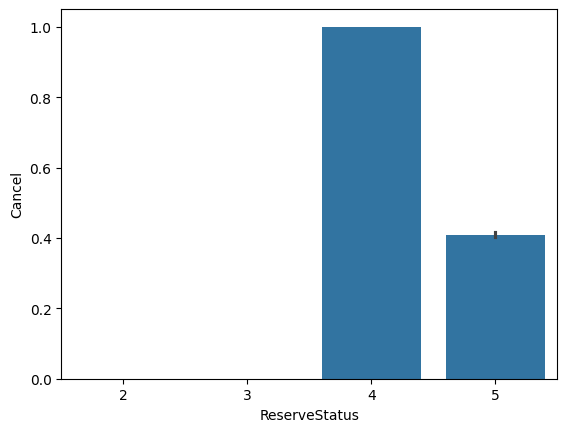

In [185]:
sns.barplot(x='ReserveStatus', y = 'Cancel', data=data)

data = data.drop(columns=['ReserveStatus'])

### Missing Values

In [186]:
missing_info = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data)) * 100
})

print(missing_info.sort_values(by='Missing Percentage', ascending=False))

                Missing Count  Missing Percentage
VehicleClass            38441           38.058512
DepartureTime               0            0.000000
Male                        0            0.000000
Price                       0            0.000000
Created                     0            0.000000
CouponDiscount              0            0.000000
From                        0            0.000000
To                          0            0.000000
Domestic                    0            0.000000
TripReason                  0            0.000000
Vehicle                     0            0.000000
Cancel                      0            0.000000
NationalCode                0            0.000000


The variable `VehicleClass` contains too many missing values to drop them, so we label them as "Unknown".

In [187]:
data['VehicleClass'] = data['VehicleClass'].fillna('Unknown')

### Correlation Check
**Vehicle=InternationalPlane - Domestic=False** 

In [188]:
print("Number of InternationalPlane:", len(data[data['Vehicle']=="InternationalPlane"]))
print("Number of Domestic=False:", len(data[data['Domestic']==0]))
print("Intersection:", len(data[(data['Vehicle']=="InternationalPlane") & (data['Domestic']==0)]))

Number of InternationalPlane: 795
Number of Domestic=False: 795
Intersection: 795


Result: clear 1-1 correlation. We manage it by merging the two categories `Plane` and `InternationalPlane`. 

In [189]:
data['Vehicle'] = data['Vehicle'].replace('InternationalPlane', 'Plane')
# Verify the merge
print("Unique categories after merge:", data['Vehicle'].unique())

Unique categories after merge: ['Plane' 'Bus' 'Train']


**Vehicle=Train - VehicleClass=Unknown**

In [190]:
print("Number of Train:", len(data[data['Vehicle']=="Train"]))
print("Number of VehicleClass=Unknown:", len(data[data['VehicleClass']=="Unknown"]))
print("Intersection:", len(data[(data['Vehicle']=="Train") & (data['VehicleClass']=="Unknown")]))

Number of Train: 38441
Number of VehicleClass=Unknown: 38441
Intersection: 38441


Result: clear 1-1 correlation.

Interpretation: it seems like for trains there is not a differentiation between standard and luxury class.

First possible solution: merge the `Unknown` class under the category `VehicleClass=0`, which means assuming that all trains only have the standard class. We check the cancellation rate in the two classes.

Cancellation Rate for Trains (Unknown Class): 18.46%
Cancellation Rate for Standard Vehicles (Class 0): 12.52%
Cancellation Rate for Luxury Vehicles (Class 1): 13.35%


<Axes: xlabel='VehicleClass', ylabel='Cancel'>

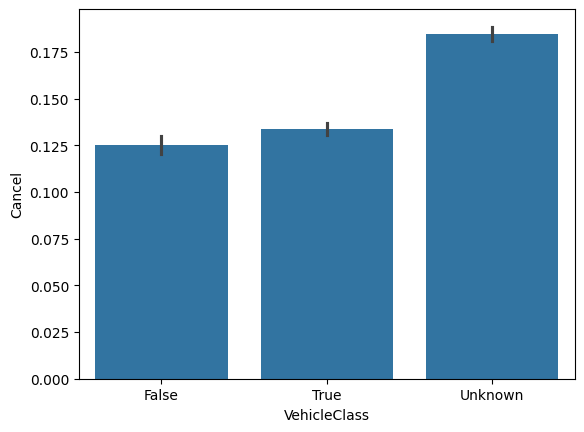

In [191]:
train_cancel_rate = data[data['Vehicle'] == 'Train']['Cancel'].mean()
standard_cancel_rate = data[data['VehicleClass'] == 0]['Cancel'].mean()
luxury_cancel_rate = data[data['VehicleClass'] == 1]['Cancel'].mean()

print(f"Cancellation Rate for Trains (Unknown Class): {train_cancel_rate:.2%}")
print(f"Cancellation Rate for Standard Vehicles (Class 0): {standard_cancel_rate:.2%}")
print(f"Cancellation Rate for Luxury Vehicles (Class 1): {luxury_cancel_rate:.2%}")

sns.barplot(x='VehicleClass', y = 'Cancel', data=data)


The $5.94\%$ difference between the cancellation rate of `VehicleClass=0` and `VehicleClass=Unknown` is pretty high, so merging the two classes would inject noise in the category. 

At the same time, the difference between the two categories `VehicleClass=0` and `VehicleClass=1` is not that relevant, so we decided to directly drop the `VehicleClass` variable, also removing correlation from the dataset.

In [192]:
data=data.drop(columns=['VehicleClass'])

## Feature Engineering

### Categorical Encoding
**Label Encoding**

`TripReason` and `Male` have 2 unique values, but different type (string, bool). For consistency and easier future management, we turn them in integers.

In [193]:
data['TripReason'] = data['TripReason'].map({'Work': 1, 'Int': 0})
data['Male'] = data['Male'].astype(int)

**One Hot Encoding**

We do one hot encoding on the variable `Vehicle`, which now contains three cathegories (Bus, Train and Plane).

In [194]:
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(data[['Vehicle']])

encoded_column = encoder.get_feature_names_out(['Vehicle'])
encoded_data = pd.DataFrame(encoded_array, columns=encoded_column)
encoded_data.index = data.index

# Drop original categorical columns and concatenate with encoded columns
data_encoded = data.drop(columns=['Vehicle'])
data = pd.concat([data_encoded, encoded_data], axis=1)

print("\nData After Encoding:")
data.info()


Data After Encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 101005 entries, 0 to 101016
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Created         101005 non-null  datetime64[ns]
 1   DepartureTime   101005 non-null  datetime64[ns]
 2   Male            101005 non-null  int64         
 3   Price           101005 non-null  float64       
 4   CouponDiscount  101005 non-null  float64       
 5   From            101005 non-null  object        
 6   To              101005 non-null  object        
 7   Domestic        101005 non-null  int64         
 8   TripReason      101005 non-null  int64         
 9   Cancel          101005 non-null  int64         
 10  NationalCode    101005 non-null  int64         
 11  Vehicle_Bus     101005 non-null  int64         
 12  Vehicle_Plane   101005 non-null  int64         
 13  Vehicle_Train   101005 non-null  int64         
dtypes: datetime64[ns](2

### Feature Extraction

- **LeadTime_Days** (float): how many days in advance the ticket was booked. 

*Hypothesis:* people who buy tickets much time in advance, are more likely to cancel due to changing of plans.

In [195]:
data['LeadTime_Days'] = (data['DepartureTime'] - data['Created']).dt.total_seconds() / 86400

- **PercentageDiscount** (float): percentage of the discount over the price.

*Hypothesis:* people who bought a ticket with a discount paid less for it, so are more prone to cancelling it; moreover, the coupon percentage is much more informative than the absolute value of discount.

However, after creating the variable we noticed that only about $6\%$ of tickets were bought with a discount, so it is a very imbalanced data and may inject noise in the model rather than being useful for prediction.

For good measure, we created the binary variable `Has_Discount` and drawn the conclusion that there is not an actual difference in cancellation rate between having or not a discount. Thus we dropped all the three of them: `CouponDiscount`, `PercentageDiscount` and `Has_Discount`.

Percentage of tickets bought with discount: 5.95%


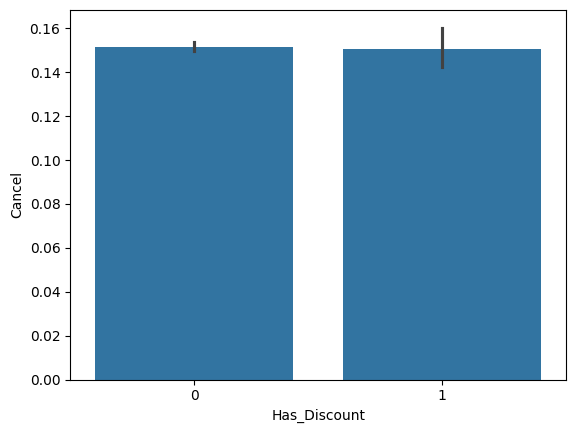

In [196]:
# as just 5% of total tickets have discount and they don't have any effect on the cancelation so we decide to drop it too

data['PercentageDiscount'] = data['CouponDiscount'] / data['Price']

print(f"Percentage of tickets bought with discount: {len(data[data['PercentageDiscount']>0])/len(data):.2%}")

data['Has_Discount'] = (data['CouponDiscount'] > 0).astype(int)
sns.barplot(x='Has_Discount', y='Cancel', data=data)

data = data.drop(columns=['CouponDiscount', 'PercentageDiscount', 'Has_Discount'])


- **LogPrice** (float)

The `Price` range is $[40000.0, 383764590.0]$ but its distribution is strongly skewed: almost all the data is squished into the bottom 0.1, with a few dots stretching way far up. There are outliers: most tickets are cheap (under 5M), but there are a few extremely expensive (100M+). These outliers can confuse linear models like Logistic Regression, so we log-transform `Price`.

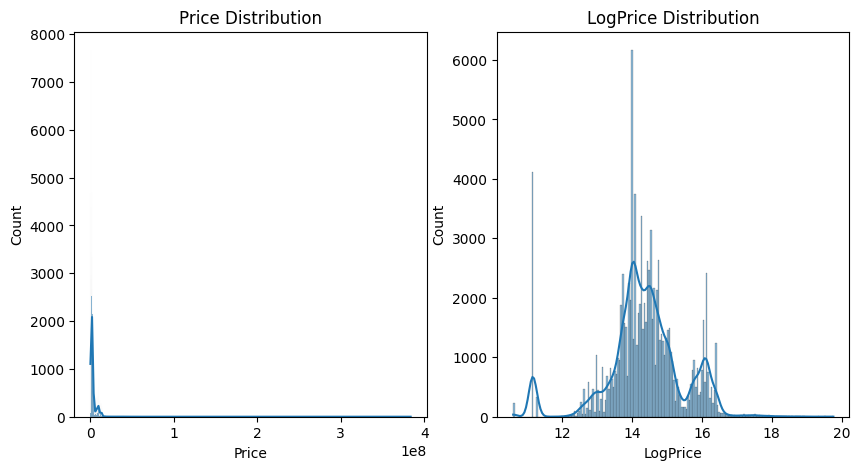

In [197]:
data['LogPrice']=np.log(data['Price'])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x='Price',data=data, kde=True, ax=axes[0])
sns.histplot(x='LogPrice',data=data, kde=True, ax=axes[1])
axes[0].set_title('Price Distribution')
axes[1].set_title('LogPrice Distribution')
plt.show()

- **MonthDeparture, DayOfWeekDeparture, HourDeparture** (datetime)
  
We analyzed the relationship between flight cancellations and various temporal features: month, day of the week, and day of the month of `DepartureTime`. Our goal was to identify seasonal or hourly patterns that influence cancellation probability.

- `HourDeparture`: A clear correlation was observed, with significantly higher cancellation rates during late-night and early-morning hours.

- `MonthDeparture`:  A sharp spike in cancellations was identified in September. However, contextual research indicates this peak coincided with the nationwide protests in Iran (Sept 2022). This represents an exogenous shock rather than a recurring seasonal trend.

- `DayOfWeekDeparture`: This variable showed a uniform distribution with no statistically significant impact on the target variable.

To prevent the model from skewing to the non-recurring events of September 2022, we will perform **outlier mitigation**: we downsample the cancelled flights for that month to align with the baseline cancellation rate of approximately $15\%$ seen in adjacent months (see `/src`). Moreover, since the primary variance was tied to a one-time event, and there are very few data for the months of January and December, this feature will later be removed to improve model generalization.

We also drop `DayOfWeekDeparture` due to its lack of predictive power, and keep `HourDeparture`, due to the consistent pattern observed.

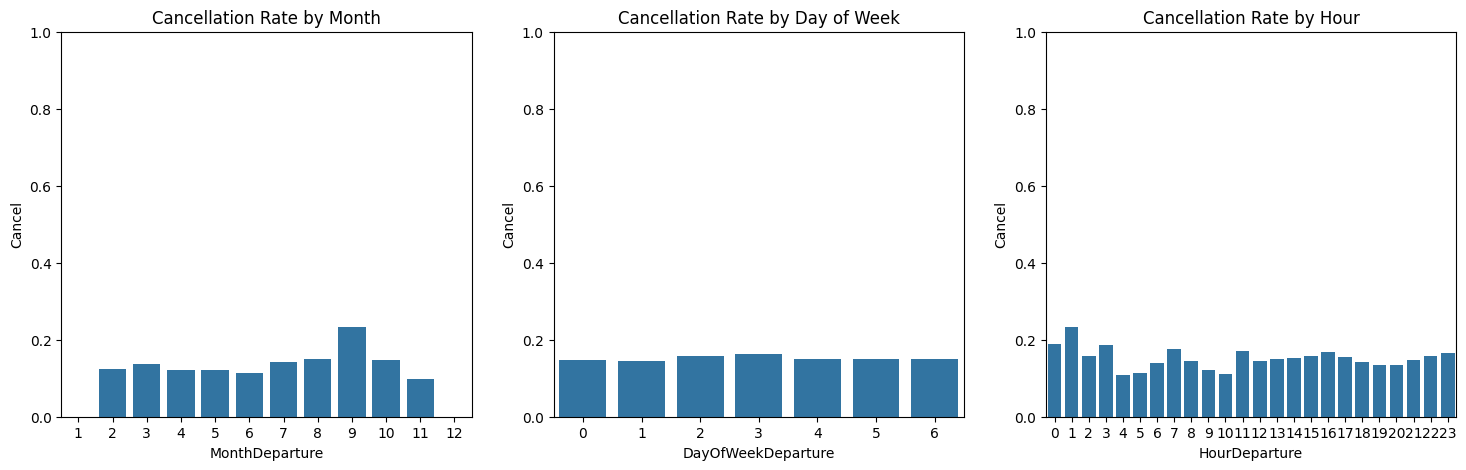

In [198]:
# Extract DepartureTime features
data['MonthDeparture'] = data['DepartureTime'].dt.month
data['DayOfWeekDeparture'] = data['DepartureTime'].dt.dayofweek
data['HourDeparture'] = data['DepartureTime'].dt.hour

# Plot Cancel Rate vs Feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Month
sns.barplot(x='MonthDeparture', y='Cancel', data=data, ax=axes[0], errorbar=None)
axes[0].set_title('Cancellation Rate by Month')
axes[0].set_ylim(0, 1) # Fix y-axis to see true scale

# Plot Day of Week
sns.barplot(x='DayOfWeekDeparture', y='Cancel', data=data, ax=axes[1], errorbar=None)
axes[1].set_title('Cancellation Rate by Day of Week')
axes[1].set_ylim(0, 1)

# Plot Hour
sns.barplot(x='HourDeparture', y='Cancel', data=data, ax=axes[2], errorbar=None)
axes[2].set_title('Cancellation Rate by Hour')
axes[2].set_ylim(0, 1)

plt.show()

data = data.drop(columns=['DepartureTime', 'DayOfWeekDeparture','MonthDeparture'])

- USER RATE THINGS

- ROUTE RATE THINGS

# Updated Dataset

In [199]:
#FINAL CHECK
print(data.isnull().sum())
print("\nRemaining Columns:", data.columns.tolist())

print("\nDataset Info:")
print(data.info())

Created          0
Male             0
Price            0
From             0
To               0
Domestic         0
TripReason       0
Cancel           0
NationalCode     0
Vehicle_Bus      0
Vehicle_Plane    0
Vehicle_Train    0
LeadTime_Days    0
LogPrice         0
HourDeparture    0
dtype: int64

Remaining Columns: ['Created', 'Male', 'Price', 'From', 'To', 'Domestic', 'TripReason', 'Cancel', 'NationalCode', 'Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'LeadTime_Days', 'LogPrice', 'HourDeparture']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 101005 entries, 0 to 101016
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Created        101005 non-null  datetime64[ns]
 1   Male           101005 non-null  int64         
 2   Price          101005 non-null  float64       
 3   From           101005 non-null  object        
 4   To             101005 non-null  object        
 5   Do

In [200]:

# #ALL THIS WILL BE DONE IN THE TRAIN/TEST SPLIT:
# # We want to know: "Is this user a high-risk person?"
# # We calculate the mean cancellation rate for each NationalCode
# user_stats = data.groupby('NationalCode')['Cancel'].agg(['mean', 'count']).reset_index()
# user_stats.columns = ['NationalCode', 'User_Cancel_Rate', 'User_Total_Tickets']

# # Merge this info back into the main dataset
# data = data.merge(user_stats, on='NationalCode', how='left')

# # NOW, we drop the NationalCode. The model will look at 'User_Cancel_Rate' instead.
# data = data.drop(columns=['NationalCode'])


In [201]:
train_df, test_df = time_based_train_test_split(data,train_size=1)
print(train_df.info())
train_df.head()

Sorting data by Created...
Split complete. Training: 101005 rows, Test: 0 rows.
Global Training Cancel Rate: 0.1516
Found 0 new users in Test set
               Route  Route_Rate
0     Shiraz to Yazd    0.187766
1  Shiraz to Zahedan    0.114594
2  Shiraz to Zahedan    0.114594
3  Shiraz to Zahedan    0.114594
4    Tehran to Rasht    0.171042
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101005 entries, 0 to 101004
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Male                101005 non-null  int64  
 1   Price               101005 non-null  float64
 2   From                101005 non-null  object 
 3   To                  101005 non-null  object 
 4   Domestic            101005 non-null  int64  
 5   TripReason          101005 non-null  int64  
 6   Cancel              101005 non-null  int64  
 7   Vehicle_Bus         101005 non-null  int64  
 8   Vehicle_Plane       101005 non-null  int

,Male,Price,From,To,Domestic,TripReason,Cancel,Vehicle_Bus,Vehicle_Plane,Vehicle_Train,LeadTime_Days,LogPrice,HourDeparture,User_Cancel_Rate,User_Total_Tickets,Route,From_Rate,To_Rate,Route_Rate
0,0,1000000.0,Shiraz,Yazd,1,0,0,1,0,0,0.121696,13.815511,23,0.0,1,Shiraz to Yazd,0.116661,0.148227,0.187766
1,1,1415000.0,Shiraz,Zahedan,1,1,0,1,0,0,0.759619,14.162640,15,0.0,1,Shiraz to Zahedan,0.116661,0.137619,0.114594
2,1,1415000.0,Shiraz,Zahedan,1,1,0,1,0,0,0.759619,14.162640,15,0.0,1,Shiraz to Zahedan,0.116661,0.137619,0.114594
3,1,1415000.0,Shiraz,Zahedan,1,1,0,1,0,0,0.759619,14.162640,15,0.0,1,Shiraz to Zahedan,0.116661,0.137619,0.114594
4,1,830000.0,Tehran,Rasht,1,1,0,1,0,0,0.109960,13.629181,23,0.0,2,Tehran to Rasht,0.155381,0.148246,0.171042


In [202]:
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Male                0 non-null      int64  
 1   Price               0 non-null      float64
 2   From                0 non-null      object 
 3   To                  0 non-null      object 
 4   Domestic            0 non-null      int64  
 5   TripReason          0 non-null      int64  
 6   Cancel              0 non-null      int64  
 7   Vehicle_Bus         0 non-null      int64  
 8   Vehicle_Plane       0 non-null      int64  
 9   Vehicle_Train       0 non-null      int64  
 10  LeadTime_Days       0 non-null      float64
 11  LogPrice            0 non-null      float64
 12  HourDeparture       0 non-null      int32  
 13  User_Cancel_Rate    0 non-null      float64
 14  User_Total_Tickets  0 non-null      int64  
 15  Route               0 non-null      object 
 16  From_Rate           

,Male,Price,From,To,Domestic,TripReason,Cancel,Vehicle_Bus,Vehicle_Plane,Vehicle_Train,LeadTime_Days,LogPrice,HourDeparture,User_Cancel_Rate,User_Total_Tickets,Route,From_Rate,To_Rate,Route_Rate


In [ ]:
#Save the two datasets
output_dir = "../data/"

os.makedirs(output_dir, exist_ok=True)

# 3. Save the DataFrames to CSV
# index=False prevents pandas from saving the row numbers as a separate column
data.to_csv(os.path.join(output_dir, "updated_data.csv"), index=False)
train_df.to_csv(os.path.join(output_dir, "train_time_based.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_time_based.csv"), index=False)